In [18]:
import cv2, os, numpy as np
from math import floor
from matplotlib import pyplot as plt

## Path Definitions

In [19]:
path_root = "/home/deniz/Desktop/CODE-ENV/data-automation/frames-to-classes/"

In [20]:
path_frames_root = path_root + "frames/"
path_frames_root

'/home/deniz/Desktop/CODE-ENV/data-automation/frames-to-classes/frames/'

In [21]:
path_classes_root = path_root + "classes/"
path_classes_root

'/home/deniz/Desktop/CODE-ENV/data-automation/frames-to-classes/classes/'

In [22]:
classes_list = os.listdir(path_classes_root)
pop_class = classes_list.pop(classes_list.index("TRASHBIN"))
classes_list.sort()
classes_list.append(pop_class)
classes_list

['blue_class', 'green_class', 'red_class', 'TRASHBIN']

In [23]:
frames_folder_name = "example_set1" #"example_set1"

path_selected_folder = path_frames_root + frames_folder_name
path_selected_folder

'/home/deniz/Desktop/CODE-ENV/data-automation/frames-to-classes/frames/example_set1'

In [24]:
image_names_list = os.listdir(path_selected_folder)
#image_names_list.sort()
num_frames = len(image_names_list)
print("number of photos:", num_frames)
image_names_list

number of photos: 3


['blue1.jpg', 'red1.jpg', 'blue2.jpg']

## Button Mapping Process

In [25]:
def button_mapping_dict(classes, button_h=100, button_w=200, image_shape=500):

    button_dict = dict()

    num_classes = len(classes)
    print("NUM CLASSES:",num_classes)

    num_columns = int(floor((num_classes * button_h) / image_shape) +1)
    print("NUM COLUMNS:", num_columns)

    pad_h = int(num_classes * button_h)
    pad_w = int(num_columns * button_w)
    pad_c = 3
    #print("GRID DIMS:", (pad_h, pad_w, pad_c))
    print("PAD DIMS:", (image_shape, pad_w, pad_c),"\n")

    # create buton pad image
    button_pad = np.zeros((image_shape, pad_w, pad_c), dtype=np.uint8)

    column = 0
    num_grid = 0

    for current_class in classes:

        color_h = np.random.randint(0,150)
        color_s = 60
        color_v = 255
        grid_color_hsv = (color_h, color_s, color_v)
        grid_color_hsv = np.uint8([[grid_color_hsv]]) 
        grid_color_rgb = cv2.cvtColor(grid_color_hsv, cv2.COLOR_HSV2BGR)
        grid_color_rgb = tuple(grid_color_rgb[0,0].tolist())
        #print(grid_color_hsv)
        
        lower_lim_y = num_grid * button_h
        upper_lim_y = lower_lim_y + button_h
        lower_lim_x = column * button_w
        upper_lim_x = lower_lim_x + button_w
        #print(f"column:{column}, iter:{num_grid} -","X:",(lower_lim_y,upper_lim_y),"Y:",(lower_lim_x,upper_lim_x), "color:", grid_color_rgb)

        button_dict[str(current_class)] = ((lower_lim_y,upper_lim_y), (lower_lim_x,upper_lim_x), current_class)

        cv2.rectangle(button_pad, (lower_lim_x, lower_lim_y), (upper_lim_x, upper_lim_y), grid_color_rgb, -1)
        cv2.putText(button_pad, str(current_class), (lower_lim_x+int(button_w*0.2), upper_lim_y-int(button_h*0.35)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        #cv2.imshow("pad", button_pad)
        #cv2.waitKey(0)

        num_grid +=1

        if upper_lim_y >= image_shape:
            column +=1
            num_grid = 0

        if column > num_columns:
            raise ValueError("Invalid column number.")

    #print(button_dict)

    print("BUTTON TABLE GENERATED:")
    print("**** PLEASE RE-RUN THIS CELL, IF THE COLORS ARE NOT HELPFUL ****\n")
    plt.imshow(cv2.cvtColor(button_pad, cv2.COLOR_BGR2RGB))

    return button_dict, button_pad

NUM CLASSES: 4
NUM COLUMNS: 1
PAD DIMS: (800, 400, 3) 

BUTTON TABLE GENERATED:
**** PLEASE RE-RUN THIS CELL, IF THE COLORS ARE NOT HELPFUL ****



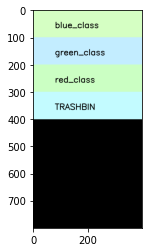

In [26]:
button_w = 400
button_h = 100
image_shape = 800
image_name = ""
path_image = ""

classes_button_dict, button_pad = button_mapping_dict(classes_list, button_h, button_w, image_shape)

## Callback Definition

In [27]:
def mouse_callback(event, click_x, click_y, flags, param):

    if event == cv2.EVENT_FLAG_LBUTTON:

        #print("CALLBACK CHECK")

        global classes_button_dict, slide
        #print(classes_button_dict)
        #print(classes_button_dict.keys())

        click_x = click_x - image_shape

        for key in classes_button_dict.keys():
            ((lower_y,upper_y), (lower_x,upper_x), current_class) = classes_button_dict[key]

            if lower_y < click_y and click_y < upper_y:
                if lower_x < click_x and click_x < upper_x:

                    path_destination = path_classes_root + current_class + "/" + image_name.split("/")[-1]
                    os.rename(path_image, path_destination)
                    print(f"MOVED TO: {current_class}")
                    #print("destination", path_destination)

                    slide = True       
               

## Main Loop

In [28]:
switch_quit = False

for image_name in image_names_list:

    # to slide next image, make "slide" True by callback func
    slide = False
    # define image path
    path_image = path_selected_folder + "/" + image_name
    print("CURRENT IMAGE PATH:", path_image)
    # read image
    image_current = cv2.imread(path_image)
    # resize image for helpful size
    image_current = cv2.resize(image_current, (image_shape,image_shape))
    # get image shape
    h,w,c = image_current.shape
    # stack image and button pad horizontally 
    image_current = np.hstack((image_current, button_pad))
    # create window for current image
    cv2.namedWindow(f"{image_name}", cv2.WINDOW_NORMAL)
    # set window property to open fullscreen
    cv2.setWindowProperty(f"{image_name}", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    # define mouse callback
    cv2.setMouseCallback(f"{image_name}",mouse_callback)
    # define information text
    info_script = f'"Q" to quit - remaining: {num_frames} - {image_name[:-4]}'
    # print information text
    cv2.putText(image_current, info_script, (15,h-15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,150,0), 2)
    # decrease remaining counter manually
    num_frames -= 1

    while True:
        
        # show current image
        cv2.imshow(f"{image_name}", image_current)

        # wait for a key
        if cv2.waitKey(20) & 0xFF == ord("q"):
            cv2.destroyWindow(f"{image_name}")
            switch_quit = True
            print(f"THE PROCESS HAS STOPPED (at '{image_name}').")
            break

        # break the loop to slide another image 
        if slide == True:
            cv2.destroyWindow(f"{image_name}")
            break

    if switch_quit:
        break

CURRENT IMAGE PATH: /home/deniz/Desktop/CODE-ENV/data-automation/frames-to-classes/frames/example_set1/blue1.jpg
THE PROCESS HAS STOPPED (at 'blue1.jpg').
